# Diet Classification - Part 3

Part 3 consist of the preprocessing and modelling of the combined datasets. Data extraction and EDA will be available in Part 1 and Part 2 respectively.

## Content

- [Data Import](#Data_Import)
- [Preprocessing and Modelling](#Preprocessing_and_Modelling)

## Data Import

In [2]:
#import vanilla python
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import preprocessing library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [3]:
#Import combine datasets
combined = pd.read_csv('../data/combined_df')
#set max row preview
pd.set_option('display.max_column', 1000)

In [4]:
combined.head()

,author,link_flair_text,num_comments,subreddit_subscribers,subreddit,text,post_datetime,date,hour,day,text_word_count
0,Elise_93,Funny,0,590954,vegan,A summary of carnist logic about PETA:,2021-04-18 02:03:10,2021-04-18,2,18,7
1,SeviathanVonEldritch,Rant,0,590952,vegan,Underestimated it as well...,2021-04-18 01:57:56,2021-04-18,1,18,4
2,quidiuris,Uncategorised,0,590952,vegan,Hair conditioner bars - any recommendations?,2021-04-18 01:55:05,2021-04-18,1,18,6
3,lunanabiki,Uncategorised,0,590953,vegan,nonvegan logic that surprises me (that i haven...,2021-04-18 01:51:11,2021-04-18,1,18,12
4,pastelprincess1,Uncategorised,0,590953,vegan,Sustainable + Ethical Alternatives Directory,2021-04-18 01:50:06,2021-04-18,1,18,5


In [5]:
#checking to ensure no null value
combined.isna().sum()

author                   0
link_flair_text          0
num_comments             0
subreddit_subscribers    0
subreddit                0
text                     0
post_datetime            0
date                     0
hour                     0
day                      0
text_word_count          0
dtype: int64

## Preprocessing and Modelling

In the preprocessing, we will start with dissecting the text table to remove special characters, like emojis, and digits which will not be critical to the this context. The words will also be filtered on the stop words before modelling.

### Removing special characters and text processing

In [6]:
#import tokenization library

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import re

In [7]:
#define tokenizer
def clean_text(words):
    """input for words/text in string to remove special characters"""
    #lowercase words
    words = words.lower()
    
    #remove other words/digit/special character
    tokenizer = RegexpTokenizer(r'[a-z]+')
    words = tokenizer.tokenize(words)
    
    #stem/lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    #remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [9]:
cleaned_text  = combined['text'].apply(clean_text)
#add col for cleaned text
combined['cleaned_text'] = cleaned_text
combined.head()

,author,link_flair_text,num_comments,subreddit_subscribers,subreddit,text,post_datetime,date,hour,day,text_word_count,cleaned_text
0,Elise_93,Funny,0,590954,vegan,A summary of carnist logic about PETA:,2021-04-18 02:03:10,2021-04-18,2,18,7,summari carnist logic peta
1,SeviathanVonEldritch,Rant,0,590952,vegan,Underestimated it as well...,2021-04-18 01:57:56,2021-04-18,1,18,4,underestim well
2,quidiuris,Uncategorised,0,590952,vegan,Hair conditioner bars - any recommendations?,2021-04-18 01:55:05,2021-04-18,1,18,6,hair condition bar ani recommend
3,lunanabiki,Uncategorised,0,590953,vegan,nonvegan logic that surprises me (that i haven...,2021-04-18 01:51:11,2021-04-18,1,18,12,nonvegan logic surpris seen yet
4,pastelprincess1,Uncategorised,0,590953,vegan,Sustainable + Ethical Alternatives Directory,2021-04-18 01:50:06,2021-04-18,1,18,5,sustain ethic altern directori


In [10]:
combined.to_csv('../data/model_data.csv',index=False)

### Modelling

Naives Bayes and Logistic Regression model will be employed for this classification model. These results will be processed through CountVectoriser and TfidfVectoriser to observed the best model pairing of prediction. The best model will then be used for final prediction. The models will be evaluated based on accuracy score. In this problem statement, we are looking for text keywords that may lead us to derive a better understanding on the keto-redditers to market vegan products better.

### Baseline Model

In [11]:
#define X and y 

X = combined['cleaned_text']
y = combined['subreddit']

In [12]:
#check proportion of both reddits
y.value_counts(normalize = True)

keto     0.507541
vegan    0.492459
Name: subreddit, dtype: float64

In [117]:
baseline = round(y.value_counts(normalize = True),3).values.max()
print(f'Baseline Accuracy: {baseline}')

Baseline Accuracy: 0.508


The above is the baseline model of accuracy 0.508 and our model is expected to outperform this score. 

In [14]:
#Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y, 
                                                    test_size= 0.33, 
                                                    random_state=42)

### Logistic Regression

#### Count Vectorization

In [15]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipe_params = {
    'cvec__max_features': [8000, 8500],
    'cvec__max_df': [0.8, 0.85],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 0.1]
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_lr_cvec = gs.best_estimator_
print('Training Accuracy: ', best_lr_cvec.score(X_train, y_train))
print('Testing Accuracy: ', best_lr_cvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9706721623335447
Testing Accuracy:  0.929835854522047




{'cvec__max_df': 0.8,
 'cvec__max_features': 8000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__C': 1,
 'lr__penalty': 'l2'}

#### Tfidf Vectorization

In [16]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear', max_iter=200, random_state=42))
])

pipe_params = {
    'tvec__max_features': [8000, 8500],
    'tvec__max_df': [0.7, 0.8],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [1, 0.1]
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_lr_tvec = gs.best_estimator_
print('Training Accuracy: ', best_lr_tvec.score(X_train, y_train))
print('Testing Accuracy: ', best_lr_tvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9580691185795814
Testing Accuracy:  0.9356292243321532




{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.7,
 'tvec__max_features': 8000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1)}

### Naive Bayes

#### Count Vectorization

In [17]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'cvec__max_features': [8000, 9000],
    'cvec__max_df': [0.3, 0.4],
    'cvec__min_df': [2, 3],
    'cvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0, 1)
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_nb_cvec = gs.best_estimator_
print('Training Accuracy: ', best_nb_cvec.score(X_train, y_train))
print('Testing Accuracy: ', best_nb_cvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.9300887761572606
Testing Accuracy:  0.9124557450917283




{'cvec__max_df': 0.4,
 'cvec__max_features': 9000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'nb__alpha': 0.1020408163265306}

#### Tfidf Vectorization

In [18]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tvec__max_features': [8000, 8500],
    'tvec__max_df': [0.4, 0.5],
    'tvec__min_df': [2, 3],
    'tvec__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0, 1)
}

gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
best_nb_tvec = gs.best_estimator_
print('Training Accuracy: ', best_nb_tvec.score(X_train, y_train))
print('Testing Accuracy: ', best_nb_tvec.score(X_test, y_test))
print('\n')
gs.best_params_

Training Accuracy:  0.937856689917565
Testing Accuracy:  0.9110074026392018




{'nb__alpha': 0.02040816326530612,
 'tvec__max_df': 0.4,
 'tvec__max_features': 8500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [119]:
#display result in dataframe
model_df = pd.DataFrame({
    'Model' :['Baseline','Logistic Regression','Logistic Regression','Naives Bayes','Naives Bayes'],
    'Vectorizer' :['','CountVectorizer','TfidfVectorizer','CountVectorizer','TfidfVectorizer'],
    'Training Accuracy' : [baseline, best_lr_cvec.score(X_train, y_train), best_lr_tvec.score(X_train, y_train), 
                           best_nb_cvec.score(X_train, y_train), best_nb_tvec.score(X_train, y_train)],
    'Test Accuracy' : ['' , best_lr_cvec.score(X_test, y_test), best_lr_tvec.score(X_test, y_test), 
                       best_nb_cvec.score(X_test, y_test), best_nb_tvec.score(X_test, y_test)]
})

model_df

,Model,Vectorizer,Training Accuracy,Test Accuracy
0,Baseline,,0.508000,
1,Logistic Regression,CountVectorizer,0.970672,0.929836
2,Logistic Regression,TfidfVectorizer,0.958069,0.935629
3,Naives Bayes,CountVectorizer,0.930089,0.912456
4,Naives Bayes,TfidfVectorizer,0.937857,0.911007


All four models have performed far better than the baseline model, which is 0.508. All four models are scoring above 0.90. 

After hyperparameter tuning, from the above table, the best model pairing is Logistic Regression with TfidfVectorizer. The training score and test score are optimized with smaller difference in both train and test score. The possible reason for the high accuracy is likely contributed from the obvious keywords, which we will investigate in later stage. 

### Model Prediction 

Based on the above evaluation, the TfidfVectorizer with Logistic Regression model will be used for as the final prediction model.

In [20]:
# prediction to actual
final_model = best_lr_tvec
final_model.fit(X_train,y_train)
preds = final_model.predict(X_test)

In [45]:
#compare ytest and prediction
pred_df = pd.DataFrame({'true_values': y_test,
                        'preds_values': preds})

pred_df

,true_values,preds_values
8760,vegan,vegan
1690,vegan,vegan
3983,vegan,vegan
3444,vegan,vegan
4674,vegan,vegan
...,...,...
16166,keto,keto
17486,keto,keto
12908,keto,keto
13699,keto,keto


## Evaluation of Model

### Confusion Matrix

Confusion Matrix helps to visualize the performance of the algorithm. We are interested in evaluation of the false positive and false negative counts.  

In [30]:
cm = confusion_matrix(y_test, preds)

In [31]:
tn,fp,fn,tp = confusion_matrix(y_test, preds).ravel()

In [32]:
print(f'True Negatives: {tn}') #predict keto is keto
print(f'False Positives: {fp}') #predict vegan but keto
print(f'False Negatives: {fn}') #predict keto but vegan
print(f'True Positives: {tp}') #predict vegan is vegan

True Negatives: 2831
False Positives: 323
False Negatives: 77
True Positives: 2983


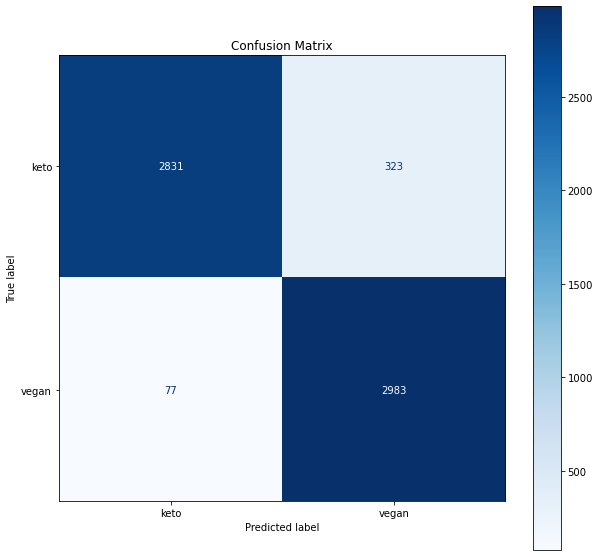

In [44]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_confusion_matrix(final_model, X_test, y_test, cmap= 'Blues', 
                  values_format='d', ax=ax );
plt.title('Confusion Matrix')
plt.savefig('../images/Confusioon_Matrix.png')
plt.show()


*Interpretation: Higher prediction for vegan text, but is actually keto text (false positive) compared to prediction for keto text but is actually vegan text(false negative). This higher false positive may indicate that vegan diet has coincide keto diet.*

In [46]:
print("Sensitivity: ", round(tp / (tp + fn),2))
print("Specificity: ", round(tn / (tn + fp),2))

Sensitivity:  0.97
Specificity:  0.9


In [47]:
print("Accuracy: ", round((tn + tp) / (tn + fp + tp + fn),2))
print("Misclassification: ", round((1-(tn + tp) / (tn + fp + tp + fn)),2))

Accuracy:  0.94
Misclassification:  0.06


The model has a high sensitivity and specificity indicating a balance model in the classification with minimum error on both false positive and false negative. The overall high accuracy at 94% is demonstrating a good model for classification of vegan vs keto. However, we will still investigate on the misclassification as our focus since we would like to look for the overlaps or keywords that has misled the model to classify otherwise.

### Misclassification

The misclassification is reviewed to make inference on the reason behind the misclassification by the model.

#### False Positive

In [102]:
#create col for predicton analysis
pred_df['success'] = np.where(pred_df['preds_values'] == pred_df['true_values'],1,0)

#missclassification on fp and fn
miss_vegan = pred_df[(pred_df.success == 0) & (pred_df.preds_values == 'vegan')]
miss_keto = pred_df[(pred_df.success == 0)  & (pred_df.preds_values == 'keto')]

#sampling a few false positive text where classification predicted as vegan but it is a keto text

print('\033[1mText 1\033[0;0m')
print(pd.DataFrame(combined.loc[miss_vegan.index])['text'][17505])
print('\n\033[1m\033[1mText 2\033[0;0m\033[0;0m')
print(pd.DataFrame(combined.loc[miss_vegan.index])['text'][9672])
print('\n\033[1mText 3\033[0;0m')
print(pd.DataFrame(combined.loc[miss_vegan.index])['text'][13515])

Text 1
Which is unhealthier gluten or dairy

Text 2
Movie timeBetter than popcorn.

Celery
Carrots
Dairy free ranch (for the kid)
Salami trio
Spinach dip 
Cheese with a coffee rub

[yum!](https://imgur.com/gallery/iBtAFnt)

I can’t believe that I haven’t thought of this before. Thank you everyone for your suggestions when I asked what to make for my daughters tea party. I did a sweet and turkey/cheese pinwheels. She loves it all.

Text 3
SV, My BMI is OverweightThe last time my BMI was normal was college. I can't believe I'm actually that cliche. Since College for the most part I would hover between 235-245.

Finally in my 30s, this week, I've gotten down to 218. (at 221 and 6' my BMI finally moves from the obese to the overweight category.)

I'm not "obese" anymore. I know, I know, that BMI is a flawed system and you shouldn't based you health on it, but it is still nice that one less mode of human categorization would call me obese.

I also know my body because I've been down to 173 

**False Positive**
Based on the above sampling text, this verifies our first observation during EDA, where the if the topic revolves around food, and recipes. However, in **Text 3** where the text consist of mostly weight loss journey were still misclassified. This will be further investigated as we review the top words of each classification.

#### False Negative

In [115]:
#sampling a few false negative text where classification predicted as keto but it is a vegan text

print('\n\033[1mText 4\033[0;0m')
print(pd.DataFrame(combined.loc[miss_keto.index])['text'][8105])
print('\n\033[1mText 5\033[0;0m')
print(pd.DataFrame(combined.loc[miss_keto.index])['text'][4092])
print('\n\033[1mText 6\033[0;0m')
print(pd.DataFrame(combined.loc[miss_keto.index])['text'][1717])


Text 4
First Week VeganSo I finally did it and changed my diet. I’m slowly adding different things to my meals, however, I didn’t have any meat or dairy this week and I feel exhausted. I’m a daily runner and just don’t have the same energy. Is this normal at first? Maybe I’m not getting enough calories or macro nutrients? I feel like I eat plenty, but maybe not. 

Any info would be helpful and thanks in advance!

Text 5
ZHOU Spirulina "Longevity Super Food" Review &amp; Taste Test

Text 6
I think too much bread was had today 🙈 how does anyone do keto 😅


**False Negative**
Based on the above sample text, **Text 4** has *'vegan'* in the text but was still wrongly classified as *'keto'* whereas for **Text 5** has food description text, similar to the false positive errors, while **Text 6** is an interesting misclassification as it contains the keto as keyword. This insights also show that **vegan** redditers are also trying **keto** diets which begs the question that would keto-dietter embrace vegan lifestyle as well.

### Word Importance

In [96]:
coef = best_lr_tvec.named_steps['lr'].coef_
feature_names = best_lr_tvec.named_steps['tvec'].get_feature_names()
word_importance = pd.Series(coef[0], feature_names).sort_values()

In [107]:
#keto
word_importance.head(20)

keto         -16.090898
carb          -7.498172
start         -4.353061
ketosi        -4.261630
weight        -4.198834
fat           -4.008643
keton         -3.641130
lb            -3.552961
pound         -3.260035
week          -3.051808
nsv           -2.996766
sugar         -2.993026
cheat         -2.966863
fast          -2.719138
macro         -2.700996
loss          -2.646992
ketogen       -2.612804
day           -2.591592
lost          -2.508440
electrolyt    -2.490443
dtype: float64

In coefficient with importance to **keto** is mainly itself (keto) and other relevant topics such as carb, weight, fat, nsv (Non Scale Victory), macro which are common terms relevant to keto diet journey. The reddit community have discussion on the new diet to try on with curiosity to find out more on how to succesfully complete the diet and lost weight fast.

In [98]:
#vegan
word_importance.tail(20)

yummi          1.538793
ban            1.540183
steak          1.553949
soy            1.572888
vegetarian     1.591618
farm           1.659998
ethic          1.680040
pig            1.782741
poll           1.789251
seitan         1.870832
human          2.041641
dairi          2.166729
milk           2.226061
base           2.237990
cow            2.283970
tofu           2.895060
meat           3.348006
plant          3.883008
anim           5.809236
vegan         14.141978
dtype: float64

Wheres for **vegan** subredditers,the keywords revolves around animal products, vegan diets, and discussion on the ethics of animal products consumption. The reddit community are awareness driven.

In retrospect to the false positive texts, we can understand the reason behind the misclassification.
**Text 1** and  **Text 2**  consist of *dairy*  which are keywords to **vegan** reddits. 
**Text 3** consist of *human* which are keywords as well for **vegan** reddits.

**Text 4** consist words *meat*, *dairy*, *calories* and *macro* which are keywords on both sides, that has tipped the favour for classification as **keto** instead of **vegan**.
**Text 5** does not have any distinctive keywords except for *food* which does not have a strong coef on the classification.
**Text 6** consist of *keto* as keyword. This shows that there are vegan-redditter trying out keto diets. 

## Conclusion & Recommendation

**Conclusion and Recommendations**
- Does the student provide appropriate context to connect individual steps back to the overall project?
- Is it clear how the final recommendations were reached?
- Are the conclusions/recommendations clearly stated?
- Does the conclusion answer the original problem statement?
- Does the student address how findings of this research can be applied for the benefit of stakeholders?
- Are future steps to move the project forward identified?